<a href="https://colab.research.google.com/github/sanagno/psychiatry-mri/blob/eeg/EEG_Final_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.svm import SVC as svm
from sklearn.linear_model import LogisticRegression as lg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,balanced_accuracy_score,f1_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter,filterwarnings
import os
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


## Clean Data


In [13]:
base_dir = './'

behaviour_data = pd.read_csv(os.path.join(base_dir, 'HBNFinalSummaries.csv'), low_memory=False)

initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[behaviour_data['NoDX'].isin(['Yes', 'No'])]
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size,
      'patients as their evaluation was incomplete.')

most_common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'No Diagnosis Given', 'Communication Disorder',
                         'Depressive Disorders']

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)] +\
                   ['DX_' + str(i).zfill(2) + '_Sub' for i in range(1, 11)]

# find users that have no diagnosis within these top diseases
# filtering should cahnge anything as this should also happen at a later stage
mask = None
for col in category_columns:
    mask_col = behaviour_data[col].isin(most_common_disorders)
    if mask is None:
        mask = mask_col
    else:
        mask = mask | mask_col

initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[mask]
behaviour_data = behaviour_data.reset_index(drop=True)
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size,
      'patients as their diagnoses were very uncommon.')

Removing 282 patients as their evaluation was incomplete.
Removing 73 patients as their diagnoses were very uncommon.


In [0]:
no_diagnosis_given = 'No Diagnosis Given'

if no_diagnosis_given in most_common_disorders:
    no_diag_index = most_common_disorders.index(no_diagnosis_given)
    most_common_disorders = most_common_disorders[:no_diag_index] + \
        most_common_disorders[no_diag_index + 1:]

In [0]:
diagnoses_to_ids = {disorder: i for i, disorder in enumerate(most_common_disorders)}

In [0]:
def get_disorder(data, row, index):
    disorder = data.iloc[row][category_columns[index]]

    if disorder == 'Neurodevelopmental Disorders':
        disorder = data.iloc[row][category_columns[index + 10]]

    return disorder

order_of_disorders = []
for k in range(behaviour_data.shape[0]):
    i = 0
    disorder = get_disorder(behaviour_data, k, i)
    disorders_patient = []
    while disorder != no_diagnosis_given and not pd.isnull(disorder):
        if disorder in diagnoses_to_ids:
            if diagnoses_to_ids[disorder] not in disorders_patient:
                disorders_patient.append(diagnoses_to_ids[disorder])
        i += 1
        if i == len(category_columns):
            break
        disorder = get_disorder(behaviour_data, k, i)

    order_of_disorders.append(disorders_patient)

In [0]:
max_len_order = np.max([len(x) for x in order_of_disorders])

# pad with a new token denoting the pad token
pad_token = len(most_common_disorders)
bod_token = len(most_common_disorders) + 1
eod_token = len(most_common_disorders) + 2

order_of_disorders = [[bod_token] + x + [eod_token] + [pad_token] * (max_len_order - len(x)) for x in order_of_disorders]

order_of_disorders = np.array(order_of_disorders)

In [0]:
classes = np.zeros((len(most_common_disorders),
                    behaviour_data.shape[0]), dtype=np.int32)

df_disorders = behaviour_data[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
        applymap(lambda x: disorder in x if pd.notnull(x) else False)

    disorder_df = df_disorders[mask.any(axis=1)]

    np.add.at(classes[i], disorder_df.index.values, 1)

In [0]:
behaviour_data_columns = behaviour_data.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX') != -1)]

behaviour_data = behaviour_data.drop(columns=columns_to_drop)

In [0]:
for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

behaviour_data['order_diagnoses'] = list(order_of_disorders)

In [0]:
behaviour_data_id=behaviour_data.EID.values

In [22]:
behaviour_data.shape

(1741, 314)

In [0]:
labels=behaviour_data[["EID","Sex","Age"]+list(most_common_disorders)]

In [24]:
labels.head()

,EID,Sex,Age,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,Communication Disorder,Depressive Disorders
0,NDARYM832PX3,1,7.048254,0,1,1,0,0,0,0
1,NDARNJ687DMC,1,6.348163,0,0,0,0,0,0,1
2,NDARRM363BXZ,0,10.052589,1,0,0,0,0,0,0
3,NDARUW586LLL,1,12.319415,0,0,0,0,0,0,1
4,NDARDC298NW4,0,13.901437,1,0,0,0,0,0,0


## EEG Data


Electroencephalography (EEG) is an electrophysiological monitoring method to record electrical activity of the brain.

In [0]:
#labels[no_diagnosis_given]=labels[no_diagnosis_given].apply(lambda x:0 if x==1 else 1)

In [0]:
#most_common_disorders=[disorder for disorder in most_common_disorders if disorder!=no_diagnosis_given]

In [25]:
most_common_disorders

['Attention-Deficit/Hyperactivity Disorder',
 'Anxiety Disorders',
 'Specific Learning Disorder',
 'Autism Spectrum Disorder',
 'Disruptive',
 'Communication Disorder',
 'Depressive Disorders']

In [26]:
eeg_mic=pd.read_csv("RestingEEG_Microstates.csv")
eeg_psd=pd.read_csv("RestingEEG_PSD_Average.csv")
eeg_spectro=pd.read_csv("RestingEEG_Spectro_Average.csv")

len(eeg_mic),len(eeg_psd),len(eeg_spectro)


(1108, 1485, 1485)

In [0]:
eeg_mic_labels=pd.merge(eeg_mic,labels,left_on='id',right_on='EID')
eeg_psd_labels=pd.merge(eeg_psd,labels,left_on='id',right_on='EID')
eeg_spectro_labels=pd.merge(eeg_spectro,labels,left_on='id',right_on='EID')

eeg_mic_labels.drop(columns=["EID"],inplace=True)
eeg_psd_labels.drop(columns=["EID"],inplace=True)
eeg_spectro_labels.drop(columns=["EID"],inplace=True)

In [28]:
labels_id=labels.EID.values
beh_full_id=behaviour_data_id.copy()

eeg_mic_id=eeg_mic.id.values

eeg_psd_id=eeg_psd.id.values

eeg_spectro_id=eeg_spectro.id.values

sum_=0
for id in eeg_mic_id:
  if id not in beh_full_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Behavioral Data and the EEG_Mic Data. (Belong to EEG but not to Behavioral)")
    
sum_=0
for id in eeg_mic_id:
  if id not in labels_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Labels and the EEG_Mic Data (Belong to EEG and  but not to Labels).")
print()

sum_=0
for id in eeg_psd_id:
  if id not in beh_full_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Behavioral Data and the EEG_PSD Data (Belong to EEG but not to Behavioral).")
    
sum_=0
for id in eeg_psd_id:
  if id not in labels_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Labels and the EEG_PSD Data (Belong to EEG but not to Labels).")
print()

sum_=0
for id in eeg_spectro_id:
  if id not in beh_full_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Behavioral Data and the EEG_Spectro Data (Belong to EEG but not to Behavioral).")
    
sum_=0
for id in eeg_spectro_id:
  if id not in labels_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Labels and the EEG_Spectro Data (Belong to EEG but not to Labels) .")






There are  180 mismatches between the Behavioral Data and the EEG_Mic Data. (Belong to EEG but not to Behavioral)
There are  180 mismatches between the Labels and the EEG_Mic Data (Belong to EEG and  but not to Labels).

There are  231 mismatches between the Behavioral Data and the EEG_PSD Data (Belong to EEG but not to Behavioral).
There are  231 mismatches between the Labels and the EEG_PSD Data (Belong to EEG but not to Labels).

There are  231 mismatches between the Behavioral Data and the EEG_Spectro Data (Belong to EEG but not to Behavioral).
There are  231 mismatches between the Labels and the EEG_Spectro Data (Belong to EEG but not to Labels) .


In [29]:
print("Microstate: {:5d} Subjects\nPSD: {:12d} Subjects\nSpectro: {:8d} Subjects".\
      format(len(eeg_mic_labels),len(eeg_psd_labels),len(eeg_spectro_labels)))



Microstate:   928 Subjects
PSD:         1254 Subjects
Spectro:     1254 Subjects


In [30]:
#Sanity check for set of EEG Feautures
if(len(set(eeg_mic_id).intersection(set(eeg_psd_id),set(eeg_spectro_id)))==len(eeg_mic_id) and \
   len(set(eeg_psd_id).intersection(set(eeg_spectro_id)))==len(eeg_psd_id)):
  print("Microstate, PSD and Spectro features contain the same subjects.")


Microstate, PSD and Spectro features contain the same subjects.


## Classification


In [0]:
def binary_classifier(x,y,conf_matrix=True,classifiers=['lgr','rf','svm'],n_splits=5,C=20,\
                      return_result=True,verbose=False):

  
  skf=StratifiedKFold(n_splits=n_splits,shuffle=True)
  
  logistic='lgr' in classifiers
  ranfor='rf' in classifiers
  suve='svm' in classifiers
  results={}

  
  
  if logistic:
    lgc=lg(C=C,class_weight='balanced',max_iter=2000,solver='liblinear')
    y_pred_lgc=np.zeros(y.shape[0])
  if ranfor:
    rfc=rf(n_estimators=100,max_depth=5,class_weight='balanced')
    y_pred_rfc=np.zeros(y.shape[0])
  
  if suve:
    
    svmc=svm(C=C,class_weight='balanced')
    y_pred_svmc=np.zeros(y.shape[0])
  
  
  for train_index, test_index in skf.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #fill missing values with mean
        col_mean = np.nanmean(x_train, axis=0)
        inds_train_nan = np.where(np.isnan(x_train))
        inds_test_nan= np.where(np.isnan(x_test))
        x_train[inds_train_nan] = np.take(col_mean, inds_train_nan[1])
        x_test[inds_test_nan]= np.take(col_mean, inds_test_nan[1])
        
        if logistic:
          lgc.fit(x_train, y_train)
          y_pred_lgc[test_index] = lgc.predict(x_test)
        if ranfor:
          rfc.fit(x_train, y_train)
          y_pred_rfc[test_index] = rfc.predict(x_test)
        if suve:
          svmc.fit(x_train, y_train)
          y_pred_svmc[test_index] = svmc.predict(x_test)

  
  if logistic:
    acc=accuracy_score(y,y_pred_lgc)
    bacc=balanced_accuracy_score(y,y_pred_lgc)
    mr=f1_score(y,y_pred_lgc)
    cof_m=confusion_matrix(y,y_pred_lgc)
    if verbose:
      print("Logistic Regression")
      print("-------------------")
      print("Accuracy :",accuracy_score(y,y_pred_lgc))
      print("Balanced Accuracy :",balanced_accuracy_score(y,y_pred_lgc))
      print("f1-score :",f1_score(y,y_pred_lgc))
      if conf_matrix:
        print(confusion_matrix(y,y_pred_lgc))
      print()
    results['lgr']=[acc,bacc,mr,cof_m]
  if ranfor:
    acc=accuracy_score(y,y_pred_rfc)
    bacc=balanced_accuracy_score(y,y_pred_rfc)
    mr=f1_score(y,y_pred_rfc)
    cof_m=confusion_matrix(y,y_pred_rfc)
    if verbose:
      print("Random Forest")
      print("-----------------")
      print("Accuracy :",accuracy_score(y,y_pred_rfc))
      print("Balanced Accuracy :",balanced_accuracy_score(y,y_pred_rfc))
      print("f1-score :",f1_score(y,y_pred_rfc))
      if conf_matrix:
        print(confusion_matrix(y,y_pred_rfc))
      print()
    results['rf']=[acc,bacc,mr,cof_m]

  if suve:
    acc=accuracy_score(y,y_pred_svmc)
    bacc=balanced_accuracy_score(y,y_pred_svmc)
    mr=f1_score(y,y_pred_svmc)
    cof_m=confusion_matrix(y,y_pred_svmc)
    if verbose:
      print("SVM")
      print("----------------")
      print("Accuracy :",accuracy_score(y,y_pred_svmc))
      print("Balanced Accuracy :",balanced_accuracy_score(y,y_pred_svmc))
      print("f1-score :",f1_score(y,y_pred_svmc))
      if conf_matrix:
        print(confusion_matrix(y,y_pred_svmc))
    results['svm']=[acc,bacc,mr,cof_m]  
  
  if return_result:
    return results    

 

In [0]:
def best_classifier(results):
  best={}
  for key_,value in results.items():
    best[key_]=sorted(value,key=lambda x:-x[1])[0]
  return best

def overall_best_result(results):
    best_per_disorder=best_classifier(results)
    results=[]
    for _,value in best_per_disorder.items():
      results.append(value[-1])

    return np.mean(results)



### EEG Microstates



EEG microstates are transient, patterned, quasi-stable states or patterns of an electroencephalogram. These tend to last anywhere from milliseconds to seconds and are hypothesized to be the most basic instantiations of human neurological tasks, and are thus nicknamed "the atoms of thought".

In [0]:
#y_none=eeg_mic_labels[no_diagnosis_given].values==0
y=eeg_mic_labels[most_common_disorders]

In [0]:
#x=eeg_mic_labels.drop(columns=["id"]+list(most_common_disorders)+[no_diagnosis_given])
x=eeg_mic_labels.drop(columns=["id"]+list(most_common_disorders))



In [36]:
x.head()

,eyesclosed_microstates_gevtotal,eyesclosed_microstates_gfp_prototype1,eyesclosed_microstates_gfp_prototype2,eyesclosed_microstates_gfp_prototype3,eyesclosed_microstates_gfp_prototype4,eyesclosed_microstates_occurence_prototype1,eyesclosed_microstates_occurence_prototype2,eyesclosed_microstates_occurence_prototype3,eyesclosed_microstates_occurence_prototype4,eyesclosed_microstates_duration_prototype1,eyesclosed_microstates_duration_prototype2,eyesclosed_microstates_duration_prototype3,eyesclosed_microstates_duration_prototype4,eyesclosed_microstates_coverage_prototype1,eyesclosed_microstates_coverage_prototype2,eyesclosed_microstates_coverage_prototype3,eyesclosed_microstates_coverage_prototype4,eyesclosed_microstates_gev_prototype1,eyesclosed_microstates_gev_prototype2,eyesclosed_microstates_gev_prototype3,eyesclosed_microstates_gev_prototype4,eyesclosed_microstates_mspatcorr_prototype1,eyesclosed_microstates_mspatcorr_prototype2,eyesclosed_microstates_mspatcorr_prototype3,eyesclosed_microstates_mspatcorr_prototype4,Sex,Age
0,0.815053,8.594640,7.840168,6.751696,6.155346,4.531579,3.605263,2.042105,1.826316,109.572590,74.712409,59.371134,61.798271,0.496537,0.269358,0.121242,0.112863,0.425801,0.179269,0.050128,0.033547,0.736561,0.707855,0.650813,0.648384,1,6.728040
1,0.725810,7.300888,6.125996,5.441025,7.418961,3.929825,2.385965,0.745614,3.421053,118.696429,69.272059,58.470588,94.902564,0.466456,0.165281,0.043596,0.324667,0.305721,0.058535,0.007259,0.176843,0.702696,0.634576,0.491432,0.630921,0,5.545744
2,0.727351,11.019322,10.683680,10.461474,10.210294,3.989474,3.515789,3.478947,2.773684,78.812665,71.227545,71.779123,66.857685,0.314421,0.250421,0.249716,0.185442,0.206668,0.148275,0.126315,0.082509,0.680067,0.669293,0.641487,0.608844,0,7.475929
3,0.800499,6.234832,6.023094,4.939876,6.024174,3.563158,3.378947,1.710526,4.084211,74.824225,73.489097,66.381538,90.966495,0.266611,0.248316,0.113547,0.371526,0.196817,0.170259,0.045047,0.252637,0.730940,0.722275,0.659675,0.710730,1,7.982660
4,0.764762,6.290508,6.239210,5.502705,5.995388,3.463158,3.484211,2.347368,3.189474,85.142857,83.519637,72.278027,76.650165,0.294863,0.291000,0.169663,0.244474,0.203649,0.203309,0.068493,0.139418,0.726088,0.715230,0.654135,0.690053,0,8.211955


In [49]:
results_acc_1={}
results_bacc_1={}
results_f1_1={}




for disorder in y.columns.values:
  print("===============",disorder,"===================")
  #x_=np.concatenate((x[y[disorder]==1].values,x[y_none].values),axis=0)
  x_=np.concatenate((x[y[disorder]==1].values,x[y[disorder]==0].values),axis=0)
  #y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y[disorder].values==0))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  
  result=binary_classifier(x_,y_)
  
  results_acc_1[disorder]=[]
  results_bacc_1[disorder]=[]
  results_f1_1[disorder]=[]
  
  for key,value in result.items():
      results_acc_1[disorder].append((key,value[0]))
      results_bacc_1[disorder].append((key,value[1]))
      results_f1_1[disorder].append((key,value[2]))
      
      
  print()


=============== Attention-Deficit/Hyperactivity Disorder ===================
Number of Subjects:  928
Positive:  559
Negative:  369


=============== Anxiety Disorders ===================
Number of Subjects:  928
Positive:  213
Negative:  715


=============== Specific Learning Disorder ===================
Number of Subjects:  928
Positive:  148
Negative:  780


=============== Autism Spectrum Disorder ===================
Number of Subjects:  928
Positive:  153
Negative:  775


=============== Disruptive ===================
Number of Subjects:  928
Positive:  152
Negative:  776


=============== Communication Disorder ===================
Number of Subjects:  928
Positive:  108
Negative:  820


=============== Depressive Disorders ===================
Number of Subjects:  928
Positive:  88
Negative:  840




### EEG PSD




Power Spectral Densities (PSD): Frequency-wise spectral power from 1-90 Hz.

In [0]:
#y_none=eeg_psd_labels[no_diagnosis_given].values==0
y=eeg_psd_labels[most_common_disorders]



In [0]:
#x=eeg_psd_labels.drop(columns=["id"]+list(most_common_disorders)+[no_diagnosis_given])
x=eeg_psd_labels.drop(columns=["id"]+list(most_common_disorders))



In [52]:
x.head()

,eyesclosed_psd_01dot00hz_average,eyesclosed_psd_01dot50hz_average,eyesclosed_psd_02dot00hz_average,eyesclosed_psd_02dot50hz_average,eyesclosed_psd_03dot00hz_average,eyesclosed_psd_03dot50hz_average,eyesclosed_psd_04dot00hz_average,eyesclosed_psd_04dot50hz_average,eyesclosed_psd_05dot00hz_average,eyesclosed_psd_05dot50hz_average,eyesclosed_psd_06dot00hz_average,eyesclosed_psd_06dot50hz_average,eyesclosed_psd_07dot00hz_average,eyesclosed_psd_07dot50hz_average,eyesclosed_psd_08dot00hz_average,eyesclosed_psd_08dot50hz_average,eyesclosed_psd_09dot00hz_average,eyesclosed_psd_09dot50hz_average,eyesclosed_psd_10dot00hz_average,eyesclosed_psd_10dot50hz_average,eyesclosed_psd_11dot00hz_average,eyesclosed_psd_11dot50hz_average,eyesclosed_psd_12dot00hz_average,eyesclosed_psd_12dot50hz_average,eyesclosed_psd_13dot00hz_average,eyesclosed_psd_13dot50hz_average,eyesclosed_psd_14dot00hz_average,eyesclosed_psd_14dot50hz_average,eyesclosed_psd_15dot00hz_average,eyesclosed_psd_15dot50hz_average,eyesclosed_psd_16dot00hz_average,eyesclosed_psd_16dot50hz_average,eyesclosed_psd_17dot00hz_average,eyesclosed_psd_17dot50hz_average,eyesclosed_psd_18dot00hz_average,eyesclosed_psd_18dot50hz_average,eyesclosed_psd_19dot00hz_average,eyesclosed_psd_19dot50hz_average,eyesclosed_psd_20dot00hz_average,eyesclosed_psd_20dot50hz_average,...,eyesopen_psd_71dot50hz_average,eyesopen_psd_72dot00hz_average,eyesopen_psd_72dot50hz_average,eyesopen_psd_73dot00hz_average,eyesopen_psd_73dot50hz_average,eyesopen_psd_74dot00hz_average,eyesopen_psd_74dot50hz_average,eyesopen_psd_75dot00hz_average,eyesopen_psd_75dot50hz_average,eyesopen_psd_76dot00hz_average,eyesopen_psd_76dot50hz_average,eyesopen_psd_77dot00hz_average,eyesopen_psd_77dot50hz_average,eyesopen_psd_78dot00hz_average,eyesopen_psd_78dot50hz_average,eyesopen_psd_79dot00hz_average,eyesopen_psd_79dot50hz_average,eyesopen_psd_80dot00hz_average,eyesopen_psd_80dot50hz_average,eyesopen_psd_81dot00hz_average,eyesopen_psd_81dot50hz_average,eyesopen_psd_82dot00hz_average,eyesopen_psd_82dot50hz_average,eyesopen_psd_83dot00hz_average,eyesopen_psd_83dot50hz_average,eyesopen_psd_84dot00hz_average,eyesopen_psd_84dot50hz_average,eyesopen_psd_85dot00hz_average,eyesopen_psd_85dot50hz_average,eyesopen_psd_86dot00hz_average,eyesopen_psd_86dot50hz_average,eyesopen_psd_87dot00hz_average,eyesopen_psd_87dot50hz_average,eyesopen_psd_88dot00hz_average,eyesopen_psd_88dot50hz_average,eyesopen_psd_89dot00hz_average,eyesopen_psd_89dot50hz_average,eyesopen_psd_90dot00hz_average,Sex,Age
0,13.252075,13.171060,10.303562,7.247638,5.177531,4.012201,3.257799,2.716654,2.334777,2.064073,1.951010,2.106707,2.599794,3.398925,5.155590,8.938139,12.533943,11.535839,6.956389,3.230759,1.504203,0.841712,0.597280,0.486366,0.416022,0.391247,0.391266,0.386449,0.366163,0.334611,0.294511,0.267583,0.273096,0.293408,0.299024,0.292122,0.284493,0.257461,0.204511,0.160624,...,0.038385,0.034233,0.032711,0.033877,0.034532,0.033885,0.033288,0.033455,0.033305,0.032292,0.031645,0.033093,0.035101,0.034616,0.033599,0.034358,0.034409,0.032573,0.030488,0.029183,0.029474,0.031485,0.032308,0.030559,0.028891,0.028484,0.028546,0.028926,0.030418,0.032051,0.030983,0.028301,0.028747,0.031572,0.032276,0.031815,0.030898,0.024803,1,6.728040
1,18.933153,16.288860,10.595218,6.793446,5.170341,4.259245,3.492614,2.900088,2.419868,2.061413,1.849428,1.643705,1.433840,1.284499,1.148665,0.957932,0.774339,0.713294,0.722093,0.685296,0.611052,0.538792,0.473819,0.421145,0.378297,0.333074,0.284930,0.253142,0.256997,0.264753,0.252979,0.235653,0.220426,0.207347,0.197353,0.196580,0.201940,0.198415,0.186404,0.174339,...,0.018009,0.017191,0.016044,0.015546,0.015629,0.016328,0.017420,0.018440,0.019046,0.019026,0.018132,0.017376,0.016868,0.016151,0.016245,0.018334,0.020296,0.019596,0.017474,0.015387,0.014524,0.015458,0.017637,0.018725,0.017394,0.015399,0.013978,0.013282,0.013946,0.014787,0.014436,0.013733,0.013491,0.013280,0.012857,0.013204,0.013635,0.011250,0,5.545744
2,22.622696,21.394408,15.648336,10.689955,8

In [53]:
results_acc_2={}
results_bacc_2={}
results_f1_2={}


for disorder in y.columns.values:
  print("===============",disorder,"===================")
  #x_=np.concatenate((x[y[disorder]==1].values,x[y_none].values),axis=0)
  x_=np.concatenate((x[y[disorder]==1].values,x[y[disorder]==0].values),axis=0)
  #y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y[disorder].values==0))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  
  result=binary_classifier(x_,y_)
  
  results_acc_2[disorder]=[]
  results_bacc_2[disorder]=[]
  results_f1_2[disorder]=[]
  for key,value in result.items():
      results_acc_2[disorder].append((key,value[0]))
      results_bacc_2[disorder].append((key,value[1]))
      results_f1_2[disorder].append((key,value[2]))
  print()

  

=============== Attention-Deficit/Hyperactivity Disorder ===================
Number of Subjects:  1254
Positive:  738
Negative:  516


=============== Anxiety Disorders ===================
Number of Subjects:  1254
Positive:  301
Negative:  953


=============== Specific Learning Disorder ===================
Number of Subjects:  1254
Positive:  208
Negative:  1046


=============== Autism Spectrum Disorder ===================
Number of Subjects:  1254
Positive:  210
Negative:  1044


=============== Disruptive ===================
Number of Subjects:  1254
Positive:  203
Negative:  1051


=============== Communication Disorder ===================
Number of Subjects:  1254
Positive:  146
Negative:  1108


=============== Depressive Disorders ===================
Number of Subjects:  1254
Positive:  114
Negative:  1140




### EEG Spectro




Spectrogram-based features, such as frequency band, individual alpha power, and FOOOF parameters.



In [0]:
#y_none=eeg_spectro_labels[no_diagnosis_given].values==0
y=eeg_spectro_labels[most_common_disorders]


In [0]:
#x=eeg_spectro_labels.drop(columns=["id"]+list(most_common_disorders)+[no_diagnosis_given])
x=eeg_spectro_labels.drop(columns=["id"]+list(most_common_disorders))



In [56]:
x.shape

(1254, 62)

In [57]:
# proportion of missing values per column with missing values
missing=sum(x.isnull().values)/x.shape[0]
for id,column in enumerate(x.columns.values):
  if (missing[id]>0):
    print(column,": ",missing[id])

x=x.drop(columns=x.columns[missing>0.2])

eyesclosed_alphapeak_max_freq :  0.1682615629984051
eyesclosed_alphapeak_max_amplitude :  0.1682615629984051
eyesclosed_alphapeak_derivative_freq :  0.15869218500797447
eyesclosed_alphapeak_derivative_amplitude :  0.15869218500797447
eyesclosed_fooof_peak_freq_average :  0.003189792663476874
eyesclosed_fooof_peak_amplitude_average :  0.003189792663476874
eyesopen_alphapeak_max_freq :  0.3277511961722488
eyesopen_alphapeak_max_amplitude :  0.3277511961722488
eyesopen_alphapeak_derivative_freq :  0.2703349282296651
eyesopen_alphapeak_derivative_amplitude :  0.2703349282296651
eyesopen_fooof_peak_freq_average :  0.004784688995215311
eyesopen_fooof_peak_amplitude_average :  0.004784688995215311


In [58]:
results_acc_3={}
results_bacc_3={}
results_f1_3={}


for disorder in y.columns.values:
  print("===============",disorder,"===================")
  #x_=np.concatenate((x[y[disorder]==1].values,x[y_none].values),axis=0)
  x_=np.concatenate((x[y[disorder]==1].values,x[y[disorder]==0].values),axis=0)
  #y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y[disorder].values==0))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  
  result=binary_classifier(x_,y_)
  
  results_acc_3[disorder]=[]
  results_bacc_3[disorder]=[]
  results_f1_3[disorder]=[]
  for key,value in result.items():
      results_acc_3[disorder].append((key,value[0]))
      results_bacc_3[disorder].append((key,value[1]))
      results_f1_3[disorder].append((key,value[2]))
  
 


=============== Attention-Deficit/Hyperactivity Disorder ===================
Number of Subjects:  1254
Positive:  738
Negative:  516

=============== Anxiety Disorders ===================
Number of Subjects:  1254
Positive:  301
Negative:  953

=============== Specific Learning Disorder ===================
Number of Subjects:  1254
Positive:  208
Negative:  1046

=============== Autism Spectrum Disorder ===================
Number of Subjects:  1254
Positive:  210
Negative:  1044

=============== Disruptive ===================
Number of Subjects:  1254
Positive:  203
Negative:  1051

=============== Communication Disorder ===================
Number of Subjects:  1254
Positive:  146
Negative:  1108

=============== Depressive Disorders ===================
Number of Subjects:  1254
Positive:  114
Negative:  1140



### All together

In [0]:
all=eeg_mic.merge(eeg_psd,how='inner',on='id')
all=all.merge(eeg_spectro,how='inner',on='id')
all_labels=all.merge(labels,how='inner',left_on='id',right_on='EID')



In [0]:
#y_none=all_labels[no_diagnosis_given]==0
y=all_labels[most_common_disorders]
#x=all_labels.drop(columns=["id"]+list(most_common_disorders)+[no_diagnosis_given])
x=all_labels.drop(columns=["id"]+list(most_common_disorders))
x.drop(columns=["EID"],inplace=True)



In [0]:
missing=sum(x.isnull().values)/x.shape[0]
x=x.drop(columns=x.columns[missing>0.2])


In [62]:
results_acc_all={}
results_bacc_all={}
results_f1_all={}


for disorder in y.columns.values:
  print("===============",disorder,"===================")
  #x_=np.concatenate((x[y[disorder]==1].values,x[y_none].values),axis=0)
  x_=np.concatenate((x[y[disorder]==1].values,x[y[disorder]==0].values),axis=0)
  #y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y[disorder].values==0))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()

  
  result=binary_classifier(x_,y_)
  
  results_acc_all[disorder]=[]
  results_bacc_all[disorder]=[]
  results_f1_all[disorder]=[]
  for key,value in result.items():
      results_acc_all[disorder].append((key,value[0]))
      results_bacc_all[disorder].append((key,value[1]))
      results_f1_all[disorder].append((key,value[2]))
  print()



=============== Attention-Deficit/Hyperactivity Disorder ===================
Number of Subjects:  928
Positive:  559
Negative:  369


=============== Anxiety Disorders ===================
Number of Subjects:  928
Positive:  213
Negative:  715


=============== Specific Learning Disorder ===================
Number of Subjects:  928
Positive:  148
Negative:  780


=============== Autism Spectrum Disorder ===================
Number of Subjects:  928
Positive:  153
Negative:  775


=============== Disruptive ===================
Number of Subjects:  928
Positive:  152
Negative:  776


=============== Communication Disorder ===================
Number of Subjects:  928
Positive:  108
Negative:  820


=============== Depressive Disorders ===================
Number of Subjects:  928
Positive:  88
Negative:  840



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Results





In [0]:
#Best scores per disorder 
#choose best classifier 

##Microstates
#best raw 
best_f1_raw_microst=best_classifier(results_f1_1)



##PSD
#best raw 
best_f1_raw_psd=best_classifier(results_f1_2)



##Spectro
#best raw
best_f1_raw_sp=best_classifier(results_f1_3)



##All Together
#best raw
best_f1_raw_all=best_classifier(results_f1_all)



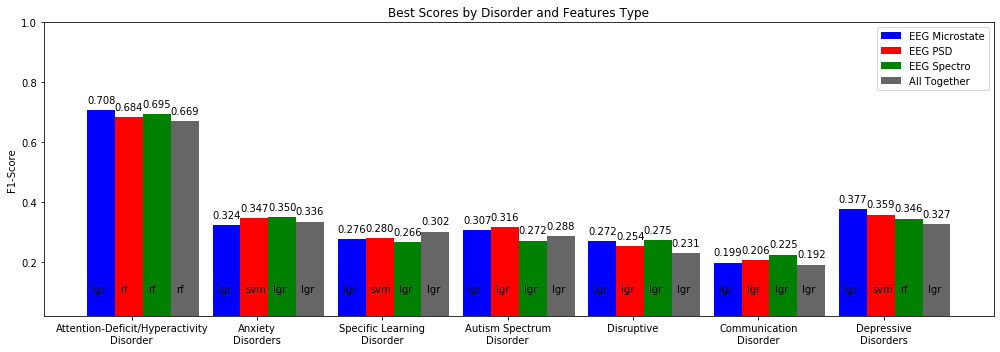

In [65]:
best_micro_=best_f1_raw_microst
best_psd_=best_f1_raw_psd
best_spectro_=best_f1_raw_sp
best_all_together_=best_f1_raw_all

best_micro=[value[-1] for _,value in best_micro_.items()]
best_micro_method=[value[0] for _,value in best_micro_.items()]
best_psd=[value[-1] for _,value in best_psd_.items()]
best_psd_method=[value[0] for _,value in best_psd_.items()]
best_spectro=[value[-1] for _,value in best_spectro_.items()]
best_spectro_method=[value[0] for _,value in best_spectro_.items()]
best_all_together=[value[-1] for _,value in best_all_together_.items()]
best_all_together_method=[value[0] for _,value in best_all_together_.items()]

labels_=['Attention-Deficit/Hyperactivity\nDisorder','Anxiety\nDisorders','Specific Learning\nDisorder','Autism Spectrum\nDisorder',\
        'Disruptive','Communication\nDisorder','Depressive\nDisorders']

x = np.arange(len(labels_))  # the label locations
width = 1/(3.5+1)  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 5))
rects1 = ax.bar(x , best_micro, width, label='EEG Microstate',color='b',)
rects2 = ax.bar(x+ width , best_psd, width, label='EEG PSD',color='r')
rects3 = ax.bar(x + 2*width, best_spectro, width, label='EEG Spectro',color='g')
rects4= ax.bar(x + 3*width, best_all_together, width, label='All Together',color='black',alpha=0.6)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1-Score')
ax.set_title('Best Scores by Disorder and Features Type')
ax.set_xticks(x+1.1*width)
ax.set_xticklabels(labels_)
ax.legend()


def autolabel(rects,best):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for i,rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/2 , height),
                     xytext=(0, 5),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')
        
        ax.annotate('{:}'.format(best[i]),xy=(rect.get_x() + rect.get_width()/2-0.07 , 0.1))



autolabel(rects1,best_micro_method)
autolabel(rects2,best_psd_method)
autolabel(rects3,best_spectro_method)
autolabel(rects4,best_all_together_method)


plt.ylim([0.02, 1])



fig.tight_layout()


plt.show()




### Repeated cross validation



In [0]:
#best classifiers per problem
micro_best=['rf','lgr','lgr','lgr','lgr','lgr','lgr']
psd_best=['rf','lgr','lgr','lgr','lgr','lgr','lgr']
spectro_best=['rf','lgr','lgr','lgr','lgr','lgr','lgr']
all_best=['rf','lgr','lgr','lgr','lgr','lgr','lgr']




In [0]:
def classify(x,y,cv,classifiers=['lgr','rf','svm'],C=20,train_all_available=False):
  
  x_=x.drop(columns=["id"])

  logistic='lgr' in classifiers
  ranfor='rf' in classifiers
  suve='svm' in classifiers
  results={}
  

  if logistic:
    lgc=lg(C=C,class_weight='balanced',max_iter=2000,solver='liblinear')
    y_pred_lgc=np.zeros(y.shape[0])
  if ranfor:
    rfc=rf(n_estimators=100,max_depth=5,class_weight='balanced')
    y_pred_rfc=np.zeros(y.shape[0])
  
  if suve:    
    svmc=svm(C=C,class_weight='balanced')
    y_pred_svmc=np.zeros(y.shape[0])
  
  
  for fold in cv:
        
    test_id=[id for id in fold]
    test_index=[id in test_id for id in x['id'].values]
    train_index=[not id for id in test_index]
    
    x_train, x_test = x_[train_index], x_[test_index]
    y_train = y[train_index]

    #fill missing values with mean
    x_train=x_train.fillna(x_train.mean(axis=0))
    x_test=x_test.fillna(x_train.mean(axis=0))
    
    if logistic:
      lgc.fit(x_train, y_train)
      y_pred_lgc[test_index] = lgc.predict(x_test)
    if ranfor:
      rfc.fit(x_train, y_train)
      y_pred_rfc[test_index]= rfc.predict(x_test)
    if suve:
      svmc.fit(x_train, y_train)
      y_pred_svmc[test_index]= svmc.predict(x_test)

  if train_all_available:
    cvs=[i for f in cv for i in f]
    test_ids=[id in cvs for id in x['id'].values]
    y=y[test_ids]
    if logistic:
      y_pred_lgc=y_pred_lgc[test_ids]
    if ranfor:
      y_pred_rfc=y_pred_rfc[test_ids]
    if suve:
      y_pred_svmc=y_pred_svmc[test_ids]
    

  if logistic:
    acc=accuracy_score(y,y_pred_lgc)
    bacc=balanced_accuracy_score(y,y_pred_lgc)
    mr=f1_score(y,y_pred_lgc)
    cof_m=confusion_matrix(y,y_pred_lgc)
    results['lgr']=[acc,bacc,mr,cof_m]

  if ranfor:
    acc=accuracy_score(y,y_pred_rfc)
    bacc=balanced_accuracy_score(y,y_pred_rfc)
    mr=f1_score(y,y_pred_rfc)
    cof_m=confusion_matrix(y,y_pred_rfc)
    results['rf']=[acc,bacc,mr,cof_m]

  if suve:
    acc=accuracy_score(y,y_pred_svmc)
    bacc=balanced_accuracy_score(y,y_pred_svmc)
    mr=f1_score(y,y_pred_svmc)
    cof_m=confusion_matrix(y,y_pred_svmc)
    results['svm']=[acc,bacc,mr,cof_m]  

  return results  

 

In [0]:
#fix cross validation 404 subjects
import pickle

# load it again
with open('cross_validation_splits.pkl', 'rb') as fid:
    cross_validation_splits = pickle.load(fid)

### Train and Test only on common subjects



We refer to common subjects as those patients which are present for Behavioral, EEG and MRI data.


In [0]:
common_subjects=[sub for lst in cross_validation_splits[0] for sub in lst ]

In [0]:
#keep common subjects
index_mic=[]
for id in eeg_mic_labels['id']:
  index_mic.append(id in common_subjects)

index_psd=[]
for id in eeg_psd_labels['id']:
  index_psd.append(id in common_subjects)

index_spectro=[]
for id in eeg_spectro_labels['id']:
  index_spectro.append(id in common_subjects)

index_all=[]
for id in all_labels['id']:
  index_all.append(id in common_subjects)

In [0]:
eeg_mic_common=eeg_mic_labels[index_mic]
eeg_psd_common=eeg_psd_labels[index_psd]
eeg_spectro_common=eeg_spectro_labels[index_spectro]
eeg_all_common=all_labels[index_all]

In [0]:
#Microstate

y=eeg_mic_common[most_common_disorders]
x=eeg_mic_common.drop(columns=list(most_common_disorders))


results_1={}


for i,disorder in enumerate(y.columns.values):

  y_=y[disorder].values
  
  clf=micro_best[i]

  results_1[disorder]=[]
  
  for cv in cross_validation_splits:      
        classifier=classify(x,y_,cv,clf)
        results_1[disorder].append(classifier)



In [0]:
accuracy_1_rep={}
bacc_1_rep={}
f1_1_rep={}

for dis in y.columns.values:
  keep=results_1[dis]
  accuracy_1_rep[dis]=[]
  bacc_1_rep[dis]=[]
  f1_1_rep[dis]=[]
  for values in keep:
    for _,val in values.items():
      accuracy_1_rep[dis].append(val[0])
      bacc_1_rep[dis].append(val[1])
      f1_1_rep[dis].append(val[2])

mean_f1_1_rep={}
mean_bacc_1_rep={}
mean_acc_1_rep={}

for dis in y.columns.values:
  keep_f1=f1_1_rep[dis]
  keep_acc=accuracy_1_rep[dis]
  keep_bacc=bacc_1_rep[dis]

  mean_f1_1_rep[dis]=np.mean(keep_f1)
  mean_bacc_1_rep[dis]=np.mean(keep_acc)
  mean_acc_1_rep[dis]=np.mean(keep_bacc)



In [0]:
#psd


y=eeg_psd_common[most_common_disorders]
x=eeg_psd_common.drop(columns=list(most_common_disorders))


results_2={}


for i,disorder in enumerate(y.columns.values):

  y_=y[disorder].values
  
  clf=psd_best[i]

  results_2[disorder]=[]
  
  for cv in cross_validation_splits:      
        classifier=classify(x,y_,cv,clf)
        results_2[disorder].append(classifier)





In [0]:
accuracy_2_rep={}
bacc_2_rep={}
f1_2_rep={}

for dis in y.columns.values:
  keep=results_2[dis]
  accuracy_2_rep[dis]=[]
  bacc_2_rep[dis]=[]
  f1_2_rep[dis]=[]
  for values in keep:
    for _,val in values.items():
      accuracy_2_rep[dis].append(val[0])
      bacc_2_rep[dis].append(val[1])
      f1_2_rep[dis].append(val[2])

mean_f1_2_rep={}
mean_bacc_2_rep={}
mean_acc_2_rep={}

for dis in y.columns.values:
  keep_f1=f1_2_rep[dis]
  keep_acc=accuracy_2_rep[dis]
  keep_bacc=bacc_2_rep[dis]

  mean_f1_2_rep[dis]=np.mean(keep_f1)
  mean_bacc_2_rep[dis]=np.mean(keep_acc)
  mean_acc_2_rep[dis]=np.mean(keep_bacc)



In [0]:
x=eeg_spectro_common.drop(columns=list(most_common_disorders))


In [78]:
#spectro
y=eeg_spectro_common[most_common_disorders]
x=eeg_spectro_common.drop(columns=list(most_common_disorders))

missing=sum(x.isnull().values)/x.shape[0]
for id,column in enumerate(x.columns.values):
  if (missing[id]>0):
    print(column,": ",missing[id])

x=x.drop(columns=x.columns[missing>0.25])


results_3={}


for i,disorder in enumerate(y.columns.values):

  y_=y[disorder].values
  
  clf=spectro_best[i]

  results_3[disorder]=[]
  
  for cv in cross_validation_splits:      
        classifier=classify(x,y_,cv,clf)
        results_3[disorder].append(classifier)




eyesclosed_alphapeak_max_freq :  0.11138613861386139
eyesclosed_alphapeak_max_amplitude :  0.11138613861386139
eyesclosed_alphapeak_derivative_freq :  0.11386138613861387
eyesclosed_alphapeak_derivative_amplitude :  0.11386138613861387
eyesclosed_fooof_peak_freq_average :  0.0024752475247524753
eyesclosed_fooof_peak_amplitude_average :  0.0024752475247524753
eyesopen_alphapeak_max_freq :  0.2747524752475248
eyesopen_alphapeak_max_amplitude :  0.2747524752475248
eyesopen_alphapeak_derivative_freq :  0.2202970297029703
eyesopen_alphapeak_derivative_amplitude :  0.2202970297029703
eyesopen_fooof_peak_freq_average :  0.0049504950495049506
eyesopen_fooof_peak_amplitude_average :  0.0049504950495049506


In [0]:
accuracy_3_rep={}
bacc_3_rep={}
f1_3_rep={}

for dis in y.columns.values:
  keep=results_3[dis]
  accuracy_3_rep[dis]=[]
  bacc_3_rep[dis]=[]
  f1_3_rep[dis]=[]
  for values in keep:
    for _,val in values.items():
      accuracy_3_rep[dis].append(val[0])
      bacc_3_rep[dis].append(val[1])
      f1_3_rep[dis].append(val[2])

mean_f1_3_rep={}
mean_bacc_3_rep={}
mean_acc_3_rep={}

for dis in y.columns.values:
  keep_f1=f1_3_rep[dis]
  keep_acc=accuracy_3_rep[dis]
  keep_bacc=bacc_3_rep[dis]

  mean_f1_3_rep[dis]=np.mean(keep_f1)
  mean_bacc_3_rep[dis]=np.mean(keep_acc)
  mean_acc_3_rep[dis]=np.mean(keep_bacc)



In [80]:
#all together


y=eeg_all_common[most_common_disorders]
x=eeg_all_common.drop(columns=list(most_common_disorders))
x.drop(columns=["EID"],inplace=True)

missing=sum(x.isnull().values)/x.shape[0]
for id,column in enumerate(x.columns.values):
  if (missing[id]>0):
    print(column,": ",missing[id])

x=x.drop(columns=x.columns[missing>0.25])

results_all={}

for i,disorder in enumerate(y.columns.values):

  y_=y[disorder].values
  
  clf=all_best[i]

  results_all[disorder]=[]
  
  for cv in cross_validation_splits:      
        classifier=classify(x,y_,cv,clf)
        results_all[disorder].append(classifier)




eyesclosed_microstates_gfp_prototype1 :  0.007425742574257425
eyesclosed_microstates_gfp_prototype2 :  0.0024752475247524753
eyesclosed_microstates_gfp_prototype3 :  0.0024752475247524753
eyesclosed_microstates_gfp_prototype4 :  0.0049504950495049506
eyesclosed_microstates_mspatcorr_prototype1 :  0.007425742574257425
eyesclosed_microstates_mspatcorr_prototype2 :  0.0024752475247524753
eyesclosed_microstates_mspatcorr_prototype3 :  0.0024752475247524753
eyesclosed_microstates_mspatcorr_prototype4 :  0.0049504950495049506
eyesclosed_alphapeak_max_freq :  0.11138613861386139
eyesclosed_alphapeak_max_amplitude :  0.11138613861386139
eyesclosed_alphapeak_derivative_freq :  0.11386138613861387
eyesclosed_alphapeak_derivative_amplitude :  0.11386138613861387
eyesclosed_fooof_peak_freq_average :  0.0024752475247524753
eyesclosed_fooof_peak_amplitude_average :  0.0024752475247524753
eyesopen_alphapeak_max_freq :  0.2747524752475248
eyesopen_alphapeak_max_amplitude :  0.2747524752475248
eyesopen

In [0]:
accuracy_all_rep={}
bacc_all_rep={}
f1_all_rep={}

for dis in y.columns.values:
  keep=results_all[dis]
  accuracy_all_rep[dis]=[]
  bacc_all_rep[dis]=[]
  f1_all_rep[dis]=[]
  for values in keep:
    for _,val in values.items():
      accuracy_all_rep[dis].append(val[0])
      bacc_all_rep[dis].append(val[1])
      f1_all_rep[dis].append(val[2])

mean_f1_all_rep={}
mean_bacc_all_rep={}
mean_acc_all_rep={}

for dis in y.columns.values:
  keep_f1=f1_all_rep[dis]
  keep_acc=accuracy_all_rep[dis]
  keep_bacc=bacc_all_rep[dis]

  mean_f1_all_rep[dis]=np.mean(keep_f1)
  mean_bacc_all_rep[dis]=np.mean(keep_acc)
  mean_acc_all_rep[dis]=np.mean(keep_bacc)



In [0]:
common_cv_rep={'acc1':accuracy_1_rep,'bacc1':bacc_1_rep,'f1_1':f1_1_rep,
                 'acc2':accuracy_2_rep,'bacc2':bacc_2_rep,'f1_2':f1_2_rep,\
                 'acc3':accuracy_3_rep,'bacc3':bacc_3_rep,'f1_3':f1_3_rep,\
                 'acc_all':accuracy_all_rep,'bacc_all':bacc_all_rep,'f1_all':f1_all_rep}


with open('common_rep_cv_results.pickle','wb') as file:
  pickle.dump(common_cv_rep,file)

### Train on available subjects, Test on common subjects



The available subjects are those patients who are present at the EEG data but not at Behabvioral and MRI data.

In [0]:
#Microstate

y=eeg_mic_labels[most_common_disorders]
x=eeg_mic_labels.drop(columns=list(most_common_disorders))


results_1_avail={}


for i,disorder in enumerate(y.columns.values):

  y_=y[disorder].values
  
  clf=micro_best[i]

  results_1_avail[disorder]=[]
  
  for cv in cross_validation_splits:      
        classifier=classify(x,y_,cv,clf,train_all_available=True)
        results_1_avail[disorder].append(classifier)



In [0]:
accuracy_1_rep_avail={}
bacc_1_rep_avail={}
f1_1_rep_avail={}

for dis in y.columns.values:
  keep=results_1_avail[dis]
  accuracy_1_rep_avail[dis]=[]
  bacc_1_rep_avail[dis]=[]
  f1_1_rep_avail[dis]=[]
  for values in keep:
    for _,val in values.items():
      accuracy_1_rep_avail[dis].append(val[0])
      bacc_1_rep_avail[dis].append(val[1])
      f1_1_rep_avail[dis].append(val[2])

mean_f1_1_rep_avail={}
mean_bacc_1_rep_avail={}
mean_acc_1_rep_avail={}

for dis in y.columns.values:
  keep_f1=f1_1_rep_avail[dis]
  keep_acc=accuracy_1_rep_avail[dis]
  keep_bacc=bacc_1_rep_avail[dis]

  mean_f1_1_rep_avail[dis]=np.mean(keep_f1)
  mean_bacc_1_rep_avail[dis]=np.mean(keep_acc)
  mean_acc_1_rep_avail[dis]=np.mean(keep_bacc)



In [0]:
#PSD

y=eeg_psd_labels[most_common_disorders]
x=eeg_psd_labels.drop(columns=list(most_common_disorders))


results_2_avail={}


for i,disorder in enumerate(y.columns.values):

  y_=y[disorder].values
  
  clf=psd_best[i]

  results_2_avail[disorder]=[]
  
  for cv in cross_validation_splits:      
        classifier=classify(x,y_,cv,clf,train_all_available=True)
        results_2_avail[disorder].append(classifier)



In [0]:
accuracy_2_rep_avail={}
bacc_2_rep_avail={}
f1_2_rep_avail={}

for dis in y.columns.values:
  keep=results_2_avail[dis]
  accuracy_2_rep_avail[dis]=[]
  bacc_2_rep_avail[dis]=[]
  f1_2_rep_avail[dis]=[]
  for values in keep:
    for _,val in values.items():
      accuracy_2_rep_avail[dis].append(val[0])
      bacc_2_rep_avail[dis].append(val[1])
      f1_2_rep_avail[dis].append(val[2])

mean_f1_2_rep_avail={}
mean_bacc_2_rep_avail={}
mean_acc_2_rep_avail={}

for dis in y.columns.values:
  keep_f1=f1_2_rep_avail[dis]
  keep_acc=accuracy_2_rep_avail[dis]
  keep_bacc=bacc_2_rep_avail[dis]

  mean_f1_2_rep_avail[dis]=np.mean(keep_f1)
  mean_bacc_2_rep_avail[dis]=np.mean(keep_acc)
  mean_acc_2_rep_avail[dis]=np.mean(keep_bacc)



In [0]:
#Spectro

y=eeg_spectro_labels[most_common_disorders]
x=eeg_spectro_labels.drop(columns=list(most_common_disorders))

missing=sum(x.isnull().values)/x.shape[0]
for id,column in enumerate(x.columns.values):
  if (missing[id]>0):
    print(column,": ",missing[id])

x=x.drop(columns=x.columns[missing>0.25])

results_3_avail={}


for i,disorder in enumerate(y.columns.values):

  y_=y[disorder].values
  
  clf=spectro_best[i]

  results_3_avail[disorder]=[]
  
  for cv in cross_validation_splits:      
        classifier=classify(x,y_,cv,clf,train_all_available=True)
        results_3_avail[disorder].append(classifier)



eyesclosed_alphapeak_max_freq :  0.1682615629984051
eyesclosed_alphapeak_max_amplitude :  0.1682615629984051
eyesclosed_alphapeak_derivative_freq :  0.15869218500797447
eyesclosed_alphapeak_derivative_amplitude :  0.15869218500797447
eyesclosed_fooof_peak_freq_average :  0.003189792663476874
eyesclosed_fooof_peak_amplitude_average :  0.003189792663476874
eyesopen_alphapeak_max_freq :  0.3277511961722488
eyesopen_alphapeak_max_amplitude :  0.3277511961722488
eyesopen_alphapeak_derivative_freq :  0.2703349282296651
eyesopen_alphapeak_derivative_amplitude :  0.2703349282296651
eyesopen_fooof_peak_freq_average :  0.004784688995215311
eyesopen_fooof_peak_amplitude_average :  0.004784688995215311


In [0]:
accuracy_3_rep_avail={}
bacc_3_rep_avail={}
f1_3_rep_avail={}

for dis in y.columns.values:
  keep=results_3_avail[dis]
  accuracy_3_rep_avail[dis]=[]
  bacc_3_rep_avail[dis]=[]
  f1_3_rep_avail[dis]=[]
  for values in keep:
    for _,val in values.items():
      accuracy_3_rep_avail[dis].append(val[0])
      bacc_3_rep_avail[dis].append(val[1])
      f1_3_rep_avail[dis].append(val[2])

mean_f1_3_rep_avail={}
mean_bacc_3_rep_avail={}
mean_acc_3_rep_avail={}

for dis in y.columns.values:
  keep_f1=f1_3_rep_avail[dis]
  keep_acc=accuracy_3_rep_avail[dis]
  keep_bacc=bacc_3_rep_avail[dis]

  mean_f1_3_rep_avail[dis]=np.mean(keep_f1)
  mean_bacc_3_rep_avail[dis]=np.mean(keep_acc)
  mean_acc_3_rep_avail[dis]=np.mean(keep_bacc)



In [0]:
#All Together

y=all_labels[most_common_disorders]
x=all_labels.drop(columns=list(most_common_disorders))
x.drop(columns=["EID"],inplace=True)

missing=sum(x.isnull().values)/x.shape[0]
for id,column in enumerate(x.columns.values):
  if (missing[id]>0):
    print(column,": ",missing[id])

x=x.drop(columns=x.columns[missing>0.25])

results_all_avail={}


for i,disorder in enumerate(y.columns.values):

  y_=y[disorder].values
  
  clf=all_best[i]

  results_all_avail[disorder]=[]
  
  for cv in cross_validation_splits:      
        classifier=classify(x,y_,cv,clf,train_all_available=True)
        results_all_avail[disorder].append(classifier)



eyesclosed_microstates_gfp_prototype1 :  0.009698275862068966
eyesclosed_microstates_gfp_prototype2 :  0.005387931034482759
eyesclosed_microstates_gfp_prototype3 :  0.005387931034482759
eyesclosed_microstates_gfp_prototype4 :  0.004310344827586207
eyesclosed_microstates_mspatcorr_prototype1 :  0.009698275862068966
eyesclosed_microstates_mspatcorr_prototype2 :  0.005387931034482759
eyesclosed_microstates_mspatcorr_prototype3 :  0.005387931034482759
eyesclosed_microstates_mspatcorr_prototype4 :  0.004310344827586207
eyesclosed_alphapeak_max_freq :  0.15086206896551724
eyesclosed_alphapeak_max_amplitude :  0.15086206896551724
eyesclosed_alphapeak_derivative_freq :  0.1497844827586207
eyesclosed_alphapeak_derivative_amplitude :  0.1497844827586207
eyesclosed_fooof_peak_freq_average :  0.0021551724137931034
eyesclosed_fooof_peak_amplitude_average :  0.0021551724137931034
eyesopen_alphapeak_max_freq :  0.30495689655172414
eyesopen_alphapeak_max_amplitude :  0.30495689655172414
eyesopen_alpha

In [0]:
accuracy_all_rep_avail={}
bacc_all_rep_avail={}
f1_all_rep_avail={}

for dis in y.columns.values:
  keep=results_all_avail[dis]
  accuracy_all_rep_avail[dis]=[]
  bacc_all_rep_avail[dis]=[]
  f1_all_rep_avail[dis]=[]
  for values in keep:
    for _,val in values.items():
      accuracy_all_rep_avail[dis].append(val[0])
      bacc_all_rep_avail[dis].append(val[1])
      f1_all_rep_avail[dis].append(val[2])

mean_f1_all_rep_avail={}
mean_bacc_all_rep_avail={}
mean_acc_all_rep_avail={}

for dis in y.columns.values:
  keep_f1=f1_all_rep_avail[dis]
  keep_acc=accuracy_all_rep_avail[dis]
  keep_bacc=bacc_all_rep_avail[dis]

  mean_f1_all_rep_avail[dis]=np.mean(keep_f1)
  mean_bacc_all_rep_avail[dis]=np.mean(keep_acc)
  mean_acc_all_rep_avail[dis]=np.mean(keep_bacc)



In [0]:
all_results_avail_rep={'acc1':accuracy_1_rep_avail,'bacc1':bacc_1_rep_avail,'f1_1':f1_1_rep_avail,
                 'acc2':accuracy_2_rep_avail,'bacc2':bacc_2_rep_avail,'f1_2':f1_2_rep_avail,\
                 'acc3':accuracy_3_rep_avail,'bacc3':bacc_3_rep_avail,'f1_3':f1_3_rep_avail,\
                 'acc_all':accuracy_all_rep_avail,'bacc_all':bacc_all_rep_avail,'f1_all':f1_all_rep_avail}

with open('avail_data_rep_cv_results.pickle', 'wb') as handle:
    pickle.dump(all_results_avail_rep, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open('avail_data_rep_cv_results.pickle','rb') as file:
   avail_cv_rep=pickle.load(file)
with open('common_rep_cv_results.pickle','rb') as file:
  common_cv_rep=pickle.load(file)

In [0]:
#f1 for common test set
avail_cv_rep_f1_1=avail_cv_rep['f1_1']
avail_cv_rep_f1_2=avail_cv_rep['f1_2']
avail_cv_rep_f1_3=avail_cv_rep['f1_3']
avail_cv_rep_f1_all=avail_cv_rep['f1_all']

#f1 for common train and test set
common_cv_rep_f1_1=common_cv_rep['f1_1']
common_cv_rep_f1_2=common_cv_rep['f1_2']
common_cv_rep_f1_3=common_cv_rep['f1_3']
common_cv_rep_f1_all=common_cv_rep['f1_all']



For EEG Microstate Attention-Deficit/Hyperactivity Disorder best classifier is RF with a score of 0.6391856944155154
For EEG PSD Attention-Deficit/Hyperactivity Disorder best classifier is RF with a score of 0.6173329186787239
For EEG Spectro Attention-Deficit/Hyperactivity Disorder best classifier is RF with a score of 0.6331183236681286
For All Attention-Deficit/Hyperactivity Disorder best classifier is RF with a score of 0.6295596866413857
For EEG Microstate Anxiety Disorders best classifier is LGR with a score of 0.3538916642640536
For EEG PSD Anxiety Disorders best classifier is LGR with a score of 0.3712973976229632
For EEG Spectro Anxiety Disorders best classifier is LGR with a score of 0.3662126981632992
For All Anxiety Disorders best classifier is LGR with a score of 0.35194005892837416
For EEG Microstate Specific Learning Disorder best classifier is LGR with a score of 0.2649349515303555
For EEG PSD Specific Learning Disorder best classifier is LGR with a score of 0.269990965

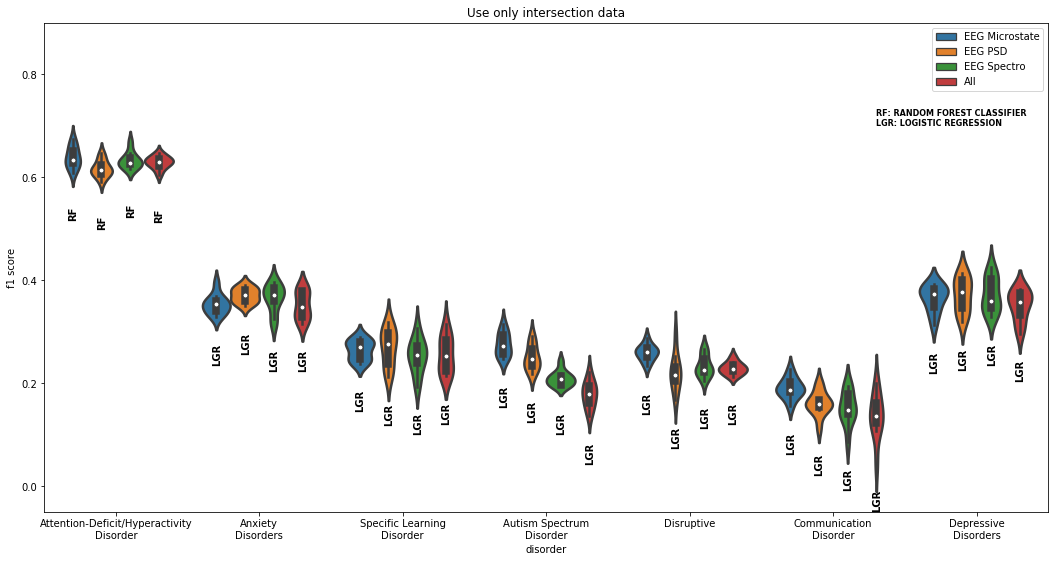

In [87]:
import seaborn as sns

plot_only_data_from_intersection = True #if true it produces the f1 scores for training and testing on the common subjects,
                                        # otherwise training on the available subjects and testing on the common subjects

micro_best=['RF','LGR','LGR','LGR','LGR','LGR','LGR']
psd_best=['RF','LGR','LGR','LGR','LGR','LGR','LGR']
spectro_best=['RF','LGR','LGR','LGR','LGR','LGR','LGR']
all_best=['RF','LGR','LGR','LGR','LGR','LGR','LGR']
bests={'EEG Microstate':micro_best, 'EEG PSD':psd_best,'EEG Spectro':spectro_best,'All':all_best}

labels_=['Attention-Deficit/Hyperactivity\nDisorder','Anxiety\nDisorders','Specific Learning\nDisorder','Autism Spectrum\nDisorder',\
         'Disruptive','Communication\nDisorder','Depressive\nDisorders']
data_configurations = ['EEG Microstate', 'EEG PSD', 'EEG Spectro', 'All']
number_of_cross_val_runs = 10

if plot_only_data_from_intersection:
     f1_bests={'EEG Microstate':common_cv_rep_f1_1, 'EEG PSD':common_cv_rep_f1_2,'EEG Spectro':common_cv_rep_f1_3,'All':common_cv_rep_f1_all}
else:
     f1_bests={'EEG Microstate':f1_1_rep_avail, 'EEG PSD':f1_2_rep_avail,'EEG Spectro':f1_3_rep_avail,'All':f1_all_rep_avail}


data_df = pd.DataFrame(columns=["f1_score", "disorder", "data_config", "classifier"])

best_classifiers = []
for most_common_disorder_i, most_common_disorder in enumerate(most_common_disorders):
    for data_configuration_i, data_configuration in enumerate(data_configurations):
        
        best_classifier = f1_bests[data_configuration][most_common_disorder]
        best_classifier_name = bests[data_configuration][most_common_disorder_i]
        best_classifiers.append(best_classifier_name)
        print('For', data_configuration, most_common_disorder, 'best classifier is', best_classifier_name, 'with a score of', np.mean(best_classifier))

        for i in range(number_of_cross_val_runs):
            data_df = data_df.append({"f1_score": best_classifier[i],
                                      "disorder": labels_[most_common_disorder_i],
                                      "data_config":  data_configuration,
                                      "classifier": best_classifier_name}, ignore_index=True)

fig, axes = plt.subplots(1, figsize=(18, 9))

sns.violinplot(x="disorder", y="f1_score", hue="data_config", ax=axes, data=data_df, linewidth=2.5)

max_deviation = 0.3

pos = 0
add_pos = - max_deviation
total = 0

text_position_=[np.min(value2) for _,value in f1_bests.items()  for _,value2 in value.items()]
text_position=[]
for ind in range(7):
  for i in range(0,len(text_position_),7):
    text_position.append(text_position_[ind+i])

for i,clf in enumerate(best_classifiers):
    # print('position', pos + add_pos)
    axes.text(pos + add_pos - 0.03, text_position[i]-0.09, clf, horizontalalignment='left', color='black', weight='semibold',rotation=90)
    # print(total, len(data_configurations), total % len(data_configurations))

    if (total + 1) % len(data_configurations) == 0:
        pos += 1
        total = 0
        add_pos = - max_deviation
    else:
        add_pos += 2 * max_deviation / (len(data_configurations) - 1)
        total += 1

axes.text(5.3,0.72,'RF: RANDOM FOREST CLASSIFIER',weight='semibold', fontsize=8)
axes.text(5.3,0.7,'LGR: LOGISTIC REGRESSION',weight='semibold', fontsize=8)
axes.set_ylim([-0.05, 0.9])
axes.set_ylabel('f1 score')

handles, labels = axes.get_legend_handles_labels()
axes.legend(handles=handles, labels=labels)

if plot_only_data_from_intersection:
    axes.set_title('Use only intersection data')
    plt.savefig('intersetion_only.png')
else:
    axes.set_title('Train on all available data')
    plt.savefig('all_data.png')

plt.show()